# import

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses, backend, constraints, initializers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from scipy.stats import kstest
from scipy.spatial.distance import jensenshannon
# from table_evaluator import load_data, TableEvaluator
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.model_selection import train_test_split

# load data

In [2]:
# folder_path = 'gtfs'

# agency = pd.read_csv(f'{folder_path}/agency.txt')
# calendar = pd.read_csv(f'{folder_path}/calendar.txt')
# calendar_dates = pd.read_csv(f'{folder_path}/calendar_dates.txt')
# fare_attributes = pd.read_csv(f'{folder_path}/fare_attributes.txt')
# fare_rules = pd.read_csv(f'{folder_path}/fare_rules.txt')
# feed_info = pd.read_csv(f'{folder_path}/feed_info.txt')
# frequencies = pd.read_csv(f'{folder_path}/frequencies.txt')
# routes = pd.read_csv(f'{folder_path}/routes.txt')
# shapes = pd.read_csv(f'{folder_path}/shapes.txt')
# stops = pd.read_csv(f'{folder_path}/stops.txt')
# stop_times = pd.read_csv(f'{folder_path}/stop_times.txt')
# transfers = pd.read_csv(f'{folder_path}/transfers.txt')
# trips = pd.read_csv(f'{folder_path}/trips.txt')

In [3]:
# join map
# # Read GTFS CSV files
# agency = pd.read_csv('gtfs/agency.txt')
# stops = pd.read_csv('gtfs/stops.txt')
# routes = pd.read_csv('gtfs/routes.txt')
# trips = pd.read_csv('gtfs/trips.txt')
# stop_times = pd.read_csv('gtfs/stop_times.txt')
# calendar = pd.read_csv('gtfs/calendar.txt')
# routes_agency = routes.merge(agency, on='agency_id', how='left')
# trips_routes = trips.merge(routes_agency, on='route_id', how='left')
# stop_times_trips = stop_times.merge(trips_routes, on='trip_id', how='left')
# stop_times_trips_stops = stop_times_trips.merge(stops, on='stop_id', how='left')
# trips_calendar = trips.merge(calendar, on='service_id', how='left')
# joined_data = stop_times_trips_stops.merge(trips_calendar, on=['trip_id', 'route_id', 'service_id'], how='left', suffixes=('', '_y'))
# joined_data = joined_data.loc[:, ~joined_data.columns.str.endswith('_y')]
# joined_data.head()

In [4]:
def load_data_collection(dir_path):
    gtfs_files = [f for f in os.listdir(dir_path)]
    data_collection = {}
    for f in gtfs_files:
        f_path = os.path.join(dir_path, f)
        data = pd.read_csv(f_path)
        if not data.empty:
            data_collection[f.split(".")[0]] = data
    return data_collection

In [5]:
# def preprocess(data_collection):
    # for k, v in data_collection.items():
    #     current_data = v.select_dtypes(include=[np.number]).astype(np.float32)
    #     scaler = StandardScaler()
    #     data_collection[k] = scaler.fit_transform(current_data)
    # return data_collection

In [6]:
def create_relation_dict(data_collection):
    relation_dict = {}
    for parent_df_name, parent_df in data_collection.items():
        parent_df_dict = {}
        for parent_col in parent_df.columns:
            for child_df_name, child_df in data_collection.items():
                if child_df_name != parent_df_name and child_df_name not in relation_dict.keys():
                    for child_col in child_df.columns:
                        if parent_col == child_col and 'id' in parent_col:
                            parent_df_dict[child_df_name] = [parent_col, child_col]
        if len(parent_df_dict.keys()) != 0:
            relation_dict[parent_df_name] = parent_df_dict
    return relation_dict

In [7]:
real_data_collection = load_data_collection("gtfs")

In [8]:
join_metadata = create_relation_dict(real_data_collection)

In [9]:
join_metadata

{'agency': {'routes': ['agency_id', 'agency_id']},
 'calendar': {'calendar_dates': ['service_id', 'service_id'],
  'trips': ['service_id', 'service_id']},
 'calendar_dates': {'trips': ['service_id', 'service_id']},
 'routes': {'trips': ['route_id', 'route_id']},
 'shapes': {'trips': ['shape_id', 'shape_id']},
 'stops': {'stop_times': ['stop_id', 'stop_id']},
 'stop_times': {'trips': ['trip_id', 'trip_id']}}

# preprocess

In [10]:
def create_preprocess_dict():
    preprocess_dict = {}
    preprocess_dict['transformation'] = {}
    preprocess_dict['transformation']['drop'] = []
    preprocess_dict['transformation']['factorize'] = []
    preprocess_dict['transformation']['to_strip'] = []
    preprocess_dict['transformation']['to_elapsed_time'] = []
    preprocess_dict['transformation']['to_elapsed_days'] = []
    preprocess_dict['nans_conversion'] = {}
    preprocess_dict['nans_conversion']['impute'] = []
    preprocess_dict['nans_conversion']['replace_with_neg_one'] = []
    preprocess_dict['nans_conversion']['replace_with_zeros'] = []
    return preprocess_dict

In [11]:
def preprocess_individual_data(data, preprocess_dict, factorization_dict, timestamp = pd.Timestamp('1900-01-01')):
    # reverse_transform_dict = {}
    for stage in preprocess_dict.keys():
        if stage == 'transformation':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'drop':
                        data = data.drop(col_list, axis=1)
                    if method == 'factorize':
                        for col in col_list:
                            data[col] = data[col].map(factorization_dict[col])
                    if method == 'to_strip':
                        for col in col_list:
                            # convert some column to numbers
                            # e.g. `123-45-6` -> `123456`
                            data[col] = data[col].str.replace(r'\D', '').astype(int)
                    if method == "to_elapsed_time":
                        for col in col_list:
                            cur_col = pd.to_timedelta(data[col])
                            cur_col = cur_col % pd.Timedelta(days=1)
                            data[col] = cur_col.dt.total_seconds()
                    if method == "to_elapsed_days":
                        for col in col_list:
                            cur_col = pd.to_datetime(data[col], format='%Y%m%d') - timestamp
                            data[col] = cur_col.dt.days
        if stage == 'nans_conversion':
            for method, col_list in preprocess_dict[stage].items():
                if len(col_list) != 0 or None:
                    if method == 'impute':
                        imputer = SimpleImputer(strategy='mean')
                        data[col_list] = imputer.fit_transform(data[col_list])
                    if method == 'replace_with_neg_one':
                        data[col_list] = data[col_list].fillna(-1)
                    if method == 'replace_with_zeros':
                        data[col_list] = data[col_list].fillna(0)
    # scaler = MinMaxScaler(feature_range=(-1, 1))
    # scaled_data = scaler.fit_transform(data)
    return data

In [12]:
def create_factorization_dict(data_collection, selected_columns):
    # Combine unique values from all DataFrames for each selected column
    unique_values = {}
    for col in selected_columns:
        local_unique_values = pd.concat([df[col] for df in data_collection.values() if col in df.columns]).unique()
        unique_values[col] = local_unique_values

    # Create a nested factorization dictionary
    factorization_dict = {}
    for col, local_unique_values in unique_values.items():
        factorization_dict[col] = {v: i for i, v in enumerate(local_unique_values)}

    return factorization_dict

In [13]:
features_to_factorize = ['agency_id','agency_name',
                         'agency_url','agency_timezone',
                         'agency_lang','service_id',
                        'feed_publisher_name','feed_publisher_url',
                        'feed_lang','feed_version',
                        'route_id','route_short_name',
                        'route_long_name','route_color',
                         'route_text_color','contract_id',
                        'shape_id','stop_id',
                        'stop_name','parent_station',
                        'platform_code','trip_id',
                        'stop_headsign','trip_headsign']
factorization_dict = create_factorization_dict(real_data_collection, features_to_factorize)

## preprocess individual data

### agency

In [14]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['agency_fare_url','agency_email']
preprocess_dict['transformation']['factorize'] = ['agency_id', 'agency_name','agency_url','agency_timezone','agency_lang']
preprocess_dict['transformation']['to_strip'] = ['agency_phone']
real_data_collection['agency'] = preprocess_individual_data(real_data_collection['agency'], preprocess_dict, factorization_dict)

C:\Users\ouzho\AppData\Local\Temp\ipykernel_23996\1225935146.py:16: FutureWarning: The default value of regex will change from True to False in a future version.
  data[col] = data[col].str.replace(r'\D', '').astype(int)


### calendar

In [15]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
real_data_collection['calendar'] = preprocess_individual_data(real_data_collection['calendar'], preprocess_dict, factorization_dict)

### calendar_dates

In [16]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['service_id']
preprocess_dict['transformation']['to_elapsed_days'] = ['date']
real_data_collection['calendar_dates'] = preprocess_individual_data(real_data_collection['calendar_dates'], preprocess_dict, factorization_dict)

### feed_info

In [17]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['feed_publisher_name',
                                                  'feed_publisher_url',
                                                 'feed_lang',
                                                 'feed_version']
preprocess_dict['transformation']['to_elapsed_days'] = ['feed_start_date','feed_end_date']
real_data_collection['feed_info'] = preprocess_individual_data(real_data_collection['feed_info'], preprocess_dict, factorization_dict)

### routes

In [18]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['drop'] = ['route_desc','route_url','route_sort_order']
preprocess_dict['transformation']['factorize'] = ['route_id',
                                                  'agency_id',
                                                 'route_short_name',
                                                 'route_long_name',
                                                 'route_color',
                                                 'route_text_color',
                                                 'contract_id']
preprocess_dict['nans_conversion']['impute'] = ['route_color','route_text_color']
real_data_collection['routes'] = preprocess_individual_data(real_data_collection['routes'], preprocess_dict, factorization_dict)

### shapes

In [19]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['shape_id']
real_data_collection['shapes'] = preprocess_individual_data(real_data_collection['shapes'], preprocess_dict, factorization_dict)

### stops

In [20]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['stop_id','stop_name','parent_station','platform_code']
preprocess_dict['transformation']['to_elapsed_days'] = ['start_date','end_date']
preprocess_dict['transformation']['drop'] = ['stop_desc','zone_id','stop_url','stop_timezone']
preprocess_dict['nans_conversion']['impute'] = ['parent_station','platform_code']
real_data_collection['stops'] = preprocess_individual_data(real_data_collection['stops'], preprocess_dict, factorization_dict)

### stop_times

In [21]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['trip_id','stop_id','stop_headsign']
preprocess_dict['transformation']['to_elapsed_time'] = ['arrival_time','departure_time']
real_data_collection['stop_times'] = preprocess_individual_data(real_data_collection['stop_times'], preprocess_dict, factorization_dict)

### trips

In [22]:
preprocess_dict = create_preprocess_dict()
preprocess_dict['transformation']['factorize'] = ['route_id','service_id','trip_id','trip_headsign','shape_id']
preprocess_dict['transformation']['drop'] = ['trip_short_name','block_id']
real_data_collection['trips'] = preprocess_individual_data(real_data_collection['trips'], preprocess_dict, factorization_dict)

## scaling

In [23]:
def batch_scaling(real_data_collection):
    scaler_dict = {}
    columns_dict = {}
    for data_name, df in real_data_collection.items():
        columns_dict[data_name] = df.columns
        scaler = MinMaxScaler(feature_range = (-1,1))
        scaler.fit(df)
        scaler_dict[data_name] = scaler
        real_data_collection[data_name] = scaler_dict[data_name].transform(df)
    return real_data_collection, scaler_dict, columns_dict

In [24]:
real_data_collection, scaler_collection, columns_dict = batch_scaling(real_data_collection)

In [25]:
columns_dict['agency'] = {'column_names':columns_dict['agency'],'primary_key':'agency_id'}
columns_dict['calendar'] = {'column_names':columns_dict['calendar'],'primary_key':'service_id'}
columns_dict['calendar_dates'] = {'column_names':columns_dict['calendar_dates'],'primary_key':'date'}
columns_dict['feed_info'] = {'column_names':columns_dict['feed_info'],'primary_key':'feed_publisher_url'}
columns_dict['routes'] = {'column_names':columns_dict['routes'],'primary_key':'route_id'}
columns_dict['shapes'] = {'column_names':columns_dict['shapes'],'primary_key':'shape_id'}
columns_dict['stops'] = {'column_names':columns_dict['stops'],'primary_key':'stop_id'}
columns_dict['stop_times'] = {'column_names':columns_dict['stop_times'],'primary_key':None}
columns_dict['trips'] = {'column_names':columns_dict['trips'],'primary_key':'trip_id'}

# Train GAN

## Sample & Noise Generation

In [26]:
def sample_data(data, size):
    return data[np.random.randint(0, data.shape[0], size)]

In [27]:
def generate_noise(n_samples, n_features):
    return np.random.uniform(-1, 1, (n_samples, n_features))

## Define Custom Setting (Wasserstein Loss)

In [28]:
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true*y_pred)

In [29]:
class ClipConstraint(constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value
        
    def __call__(self, weights):
        return backend.clip(weights, -self.clip_value, self.clip_value)
    
    def get_config(self):
        return {'clip_value': self.clip_value}

## Define Plotting Function For G/D Loss

In [30]:
import matplotlib.pyplot as plt

def plot_history(logs):
    n = len(logs)
    n_rows = (n + 2) // 3

    fig, axes = plt.subplots(n_rows, 3, figsize=(15, 5 * n_rows), sharex=True, sharey=True)
    axes = axes.flatten()

    for i, (model_name, generator_log, discriminator_log) in enumerate(logs):
        axes[i].plot(generator_log, label='gen')
        axes[i].plot(discriminator_log, label='d')
        axes[i].legend()
        axes[i].set_title(model_name)

    for i in range(n, n_rows * 3):
        axes[i].remove()

    plt.tight_layout()
    plt.show()
    plt.close()

## (!) Define Main Generator, Discriminator, WGAN Function

In [31]:
def build_generator(input_dim, output_dim):
    model = models.Sequential()
    model.add(layers.Dense(units=128,
                           input_dim=input_dim,
                           kernel_initializer='HeUniform',
                           activation='LeakyReLU'))
    model.add(layers.BatchNormalization())
    # model.add(layers.Dense(units=64, activation='LeakyReLU'))
    # model.add(layers.Dense(units=64, activation='LeakyReLU'))
    model.add(layers.Reshape((4, 32)))
    model.add(layers.Conv1DTranspose(64,
                                     kernel_size=3,
                                     strides=2,
                                     padding="same",
                                     activation="LeakyReLU"))
    model.add(layers.Conv1DTranspose(32,
                                     kernel_size=3,
                                     strides=2,
                                     padding="same",
                                     activation="LeakyReLU"))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(units=output_dim, activation='tanh'))
    return model

In [32]:
def build_discriminator(input_dim, constraint_rate=0.01, optimization_rate=0.00005):
    clip_const = ClipConstraint(constraint_rate)
    rms_opt = optimizers.RMSprop(optimization_rate)
    model = models.Sequential()
    n_chunks = 4
    n_features = input_dim // n_chunks
    model.add(layers.Dense(64,
                           input_dim=input_dim,
                           kernel_initializer='HeUniform',
                           kernel_constraint=clip_const,
                           activation='LeakyReLU'))
    # model.add(layers.Input(shape=(n_chunks, n_features)))
    model.add(layers.BatchNormalization())
    model.add(layers.Reshape((4, 16)))
    # model.add(layers.Conv1D(64,
    #                         kernel_size=4,
    #                         strides=2,
    #                         padding="same",
    #                         kernel_constraint=clip_const,
    #                         activation="LeakyReLU"))
    model.add(layers.Conv1D(64,
                            kernel_size=4,
                            strides=2,
                            padding="same",
                            kernel_constraint=clip_const,
                            activation="LeakyReLU"))
    model.add(layers.Conv1D(64,
                            kernel_size=4,
                            strides=2,
                            padding="same",
                            kernel_constraint=clip_const,
                            activation="LeakyReLU"))
    # model.add(layers.Dense(64, kernel_constraint=clip_const, activation='LeakyReLU'))
    # model.add(layers.Dense(64, kernel_constraint=clip_const, activation='LeakyReLU'))
    model.add(layers.BatchNormalization())
    model.add(layers.Flatten())
    model.add(layers.Dense(units=1, activation='linear'))
    model.compile(loss=wasserstein_loss,
                  optimizer=rms_opt, metrics=['binary_accuracy'])
    return model

In [33]:
def build_gan(generator, discriminator, optimization_rate=0.00005):
    rms_opt = optimizers.RMSprop(optimization_rate)
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss=wasserstein_loss,
                 optimizer=rms_opt)
    return model

## Define Training Strategy

In [34]:
def train_gan(real_data_collection, epochs=25, batch_size=128, seed=123):
    generator_collection = {}
    shape_info_collection = {}
    logs = []
    
    for k, v in real_data_collection.items():
        random.seed(seed)
        generator_log = []
        discriminator_log = []
        real_data = v
        n_features = real_data.shape[1]
        shape_info_collection[k] = real_data.shape
        
        generator = build_generator(n_features, n_features)
        discriminator = build_discriminator(n_features)
        gan = build_gan(generator, discriminator)
        
        for epoch in range(epochs):
            
            noise = generate_noise(batch_size, n_features)
            
            X_real = sample_data(real_data, batch_size)
            X_fake = generator.predict(noise)
            y_real = -1 * np.ones((batch_size, 1))
            y_fake = np.ones((batch_size, 1))
            
            d_loss_real, _ = discriminator.train_on_batch(X_real, y_real)
            d_loss_fake, _ = discriminator.train_on_batch(X_fake, y_fake)
            
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            g_loss = gan.train_on_batch(noise, y_real)
            generator_log.append(g_loss)
            discriminator_log.append(d_loss)
            # if epoch % 10 == 0 or epoch == epochs:
            print(f"Dataset: \"{k}\" [Epoch: {epoch+1}] [D loss: {np.round(d_loss, 3)}] [G loss: {np.round(g_loss, 3)}]")
        logs.append([k, generator_log,discriminator_log])
        generator_collection[k] = generator
    plot_history(logs)   
    return generator_collection

## Train WGAN

Dataset: "agency" [Epoch: 1] [D loss: 0.001] [G loss: -0.0]
Dataset: "agency" [Epoch: 2] [D loss: 0.0] [G loss: -0.0]
Dataset: "agency" [Epoch: 3] [D loss: 0.0] [G loss: -0.001]
Dataset: "agency" [Epoch: 4] [D loss: 0.0] [G loss: -0.001]
Dataset: "agency" [Epoch: 5] [D loss: 0.0] [G loss: -0.001]
Dataset: "agency" [Epoch: 6] [D loss: 0.0] [G loss: -0.001]
Dataset: "agency" [Epoch: 7] [D loss: 0.0] [G loss: -0.001]
Dataset: "agency" [Epoch: 8] [D loss: 0.0] [G loss: -0.001]
Dataset: "agency" [Epoch: 9] [D loss: 0.0] [G loss: -0.001]
Dataset: "agency" [Epoch: 10] [D loss: 0.0] [G loss: -0.001]
Dataset: "agency" [Epoch: 11] [D loss: 0.0] [G loss: -0.001]
Dataset: "agency" [Epoch: 12] [D loss: 0.0] [G loss: -0.001]
Dataset: "agency" [Epoch: 13] [D loss: 0.0] [G loss: -0.001]
Dataset: "agency" [Epoch: 14] [D loss: 0.0] [G loss: -0.001]
Dataset: "agency" [Epoch: 15] [D loss: 0.0] [G loss: -0.001]
Dataset: "agency" [Epoch: 16] [D loss: 0.0] [G loss: -0.001]
Dataset: "agency" [Epoch: 17] [D lo

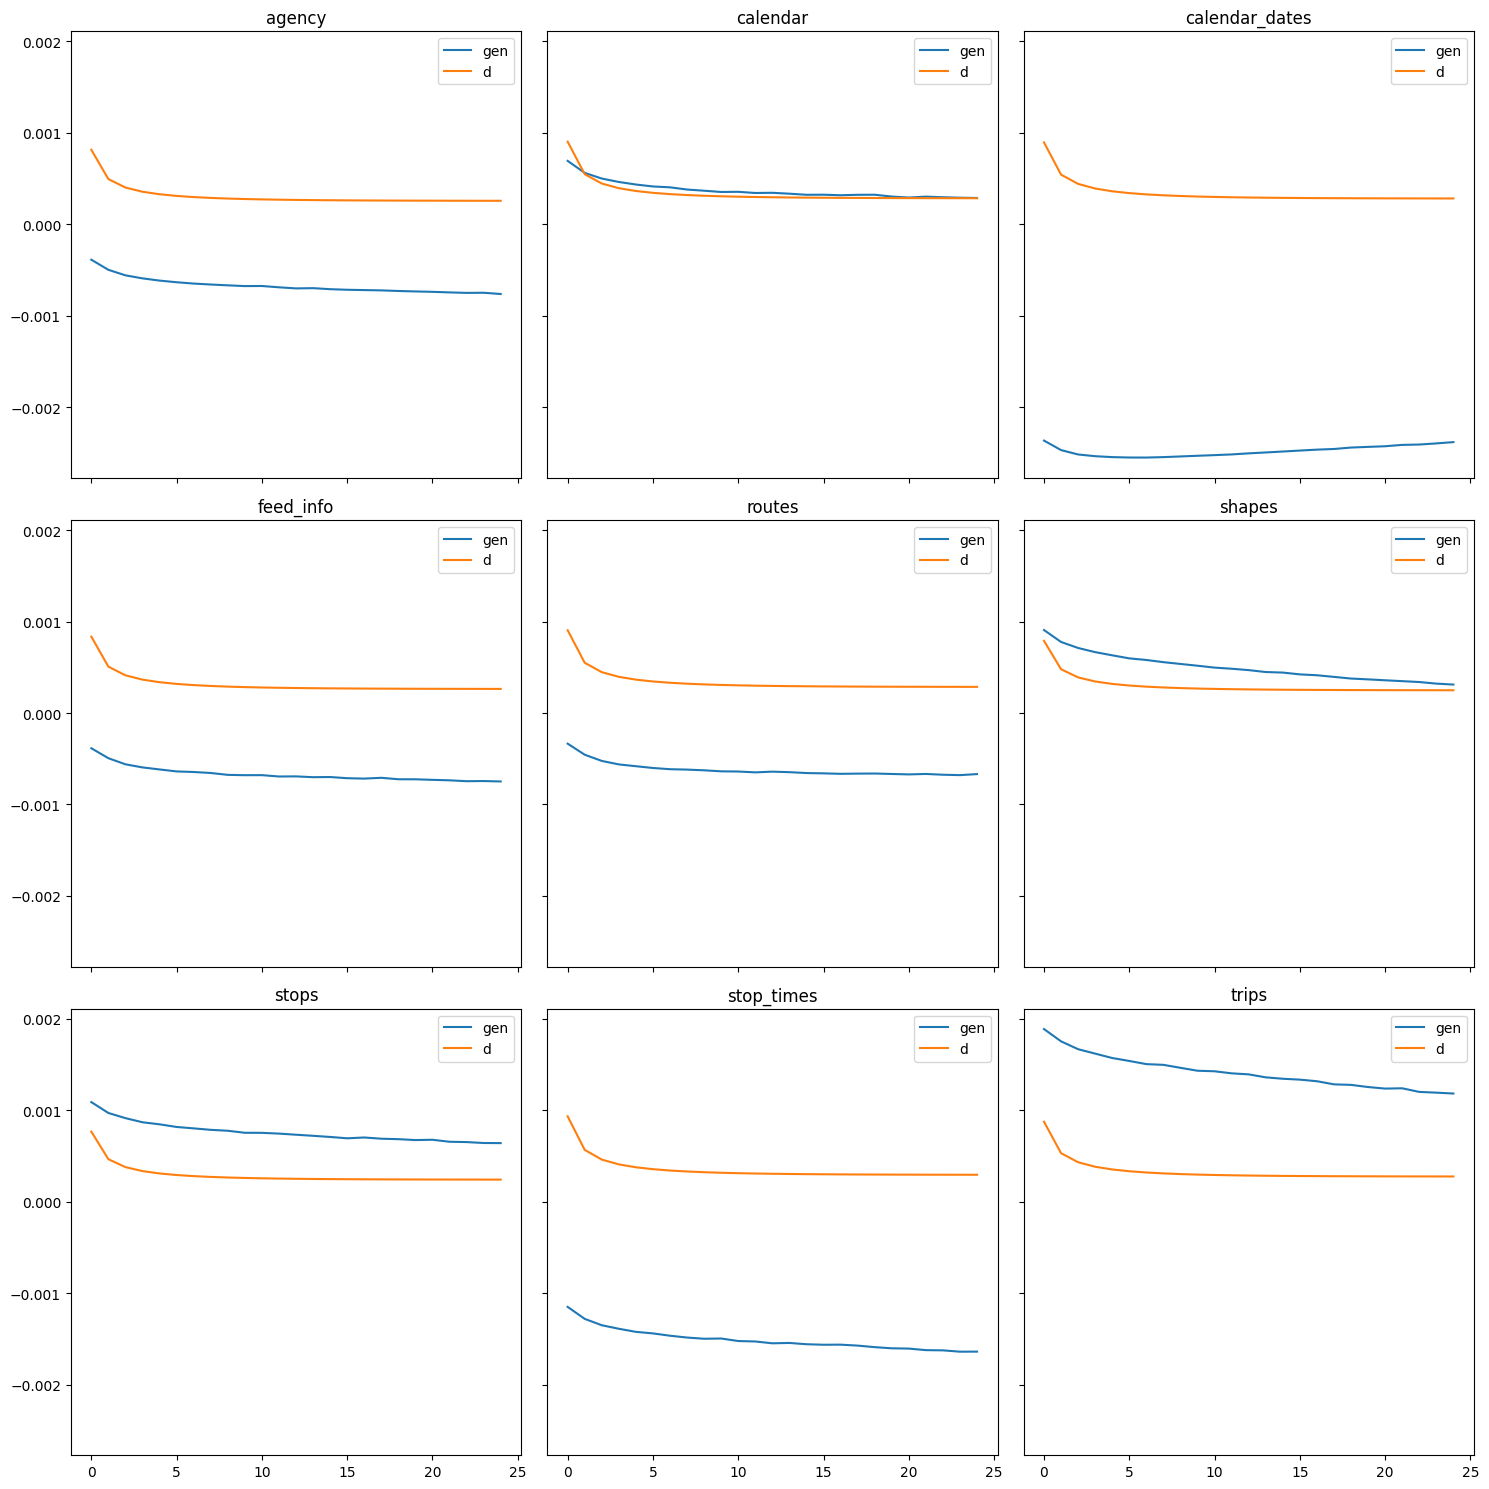

In [35]:
generator_collection = train_gan(real_data_collection)

# Synthetic Data Generation and Reverse-Transformation

In [36]:
# def generate_synthetic_tables(generators, join_metadata, columns_dict, scalers, rows_to_generate):
#     synthetic_data = {}
#     for table_name, generator in generators.items():
#         if isinstance(rows_to_generate, int):
#             n_rows = rows_to_generate
#         elif isinstance(rows_to_generate, dict):
#             n_rows = rows_to_generate[table_name]
#         else:
#             raise ValueError("rows_to_generate must be either an int or a dict")

#         noise = np.random.normal(0, 1, (n_rows, generator.input_shape[1]))
#         synthetic_rows = generator.predict(noise)

#         synthetic_rows = scalers[table_name].inverse_transform(synthetic_rows)

#         synthetic_table = pd.DataFrame(synthetic_rows, columns=columns_dict[table_name])
        
#         for col in synthetic_table.columns:
#             if 'id' in col:
#                 synthetic_table[col] = synthetic_table[col].round().astype(int)

#         synthetic_data[table_name] = synthetic_table

#     for table_name, related_tables in join_metadata.items():
#         for related_table_name, (table_key, related_table_key) in related_tables.items():
#             synthetic_data[table_name] = pd.merge(synthetic_data[table_name],
#                                                   synthetic_data[related_table_name],
#                                                   left_on=table_key,
#                                                   right_on=related_table_key,
#                                                   suffixes=('', f'_{related_table_name}'))

#     return synthetic_data

In [37]:
# def generate_synthetic_tables(generators, join_metadata, columns_dict, scalers, rows_to_generate):
#     synthetic_data = {}
#     key_mappings = {}
    
#     for table_name, generator in generators.items():
#         if isinstance(rows_to_generate, int):
#             n_rows = rows_to_generate
#         elif isinstance(rows_to_generate, dict):
#             n_rows = rows_to_generate[table_name]
#         else:
#             raise ValueError("rows_to_generate must be either an int or a dict")


#         noise = np.random.normal(0, 1, (n_rows, generator.input_shape[1]))
#         synthetic_rows = generator.predict(noise)

#         synthetic_rows = scalers[table_name].inverse_transform(synthetic_rows)

#         synthetic_table = pd.DataFrame(synthetic_rows, columns=columns_dict[table_name])

#         for col in synthetic_table.columns:
#             if 'id' in str(col):
#                 synthetic_table[col] = synthetic_table[col].round().astype(int)

#         synthetic_data[table_name] = synthetic_table

#     for table_name, related_tables in join_metadata.items():
#         for related_table_name, (table_key, related_table_key) in related_tables.items():
#             if table_key not in key_mappings:

#                 key_mappings[table_key] = synthetic_data[table_name][table_key].unique()

#             synthetic_data[related_table_name][related_table_key] = np.random.choice(
#                 key_mappings[table_key],
#                 size=len(synthetic_data[related_table_name])
#             )

#     return synthetic_data

In [38]:
# def columns_to_int(df, columns_to_include=None, columns_to_ignore=None):
#     all_column_names = df.columns.tolist()
#     if columns_to_include:
#         for col in all_columns_names:
#             df[col] = df[col].round().astype(int)
#     elif columns_to_ignore:
#         columns_to_include = [col for col in all_column_names if col not in columns_to_ignore]
#         for col in all_column_names:
#             df[col] = df[col].round().astype(int)

In [39]:
def reverse_transform(data, scaler, column_names, rounding=True, features_to_factorize=None, features_to_ignore=None):
    this_data = scaler.inverse_transform(data)
    this_data = pd.DataFrame(this_data, columns=column_names)
    # round factor columns to nearest int
    if rounding:
        if features_to_factorize:
            for col in column_names:
                this_data[col] = this_data[col].round().astype(int)
        elif features_to_ignore:
            columns_to_include = [col for col in column_names if col not in features_to_ignore]
            for col in column_names:
                this_data[col] = this_data[col].round().astype(int)
    return this_data

In [40]:
def generate_synthetic_tables(generators,join_metadata,columns_dict,scalers,features_to_factorize=None,features_to_ignore=None,rows_to_generate=10):
    synthetic_data = {}
    key_mappings = {}
    
    # check if `rows_to_generate` is a number or dictionary
    # if it's a nmber, generate equal number of rows for all tables.
    # if it's a dict, generate corresponding number of rows, useful for table with id as primary key.
    for table_name, generator in generators.items():
        if isinstance(rows_to_generate, int):
            n_rows = rows_to_generate
        elif isinstance(rows_to_generate, dict):
            n_rows = rows_to_generate[table_name]
        else:
            raise ValueError("rows_to_generate must be either an int or a dict")

        # generate synthetic data
        noise = np.random.normal(0, 1, (n_rows, generator.input_shape[1]))
        synthetic_table = generator.predict(noise)
        
#         # reverse transformation
#         synthetic_rows = scalers[table_name].inverse_transform(synthetic_rows)

#         # convert to dataframe, add column header for join relation check
#         synthetic_table = pd.DataFrame(synthetic_rows, columns=columns_dict[table_name]['column_names'])
        
        synthetic_table = reverse_transform(synthetic_table,
                                            scalers[table_name],
                                            columns_dict[table_name]['column_names'],
                                            rounding=True,
                                            features_to_factorize=features_to_factorize,
                                            features_to_ignore=features_to_ignore)

        # make the primary key columns unique
        primary_key = columns_dict[table_name]['primary_key']
        if primary_key is not None:
            synthetic_table[primary_key] = np.arange(0, len(synthetic_table))

        synthetic_data[table_name] = synthetic_table

    # relation mapping
    for table_name, related_tables in join_metadata.items():
        # iterate each table, use primary key as reference, map the foreign key
        for related_table_name, (table_key, related_table_key) in related_tables.items():
            # ensure and make the primary key column unique
            if table_key not in key_mappings:
                key_mappings[table_key] = synthetic_data[table_name][table_key].unique()
            
            # ensure the foreign key exist from the parent table
            # map foreign key from the parent primary key
            synthetic_data[related_table_name][related_table_key] = np.random.choice(
                key_mappings[table_key],
                size=len(synthetic_data[related_table_name] )
            )

    return synthetic_data

In [41]:
features_to_ignore = ['shape_pt_lat',
                      'shape_pt_lon',
                      'stop_lat',
                      'stop_lon',
                     'shape_dist_traveled']

In [42]:
rows_to_generate = {k:v.shape[0] for k,v in real_data_collection.items()}

synthetic_data_collection = generate_synthetic_tables(generator_collection,
                                                      join_metadata,
                                                      columns_dict,
                                                      scaler_collection,
                                                      None,
                                                      features_to_ignore,
                                                      rows_to_generate)

In [43]:
synthetic_data_collection

{'agency':     agency_id  agency_name  agency_url  agency_timezone  agency_lang  \
 0           0            4           0                1            0   
 1           1            5           0                1            1   
 2           2            4           0                1            1   
 3           3            4           0                1            0   
 4           4            1           1                1            1   
 5           5            5           0                1            1   
 6           6            4           0                1            0   
 7           7            2           0                1            1   
 8           8            5           0                1            0   
 9           9            6           0                1            0   
 10         10            2           0                1            1   
 11         11            4           0                0            0   
 12         12            6           0  

In [44]:
real_data_collection = {k:reverse_transform(v,scaler_collection[k],columns_dict[k]['column_names'],rounding=True,features_to_factorize=None, features_to_ignore=features_to_ignore) for k,v in real_data_collection.items()}

In [45]:
real_data_collection

{'agency':     agency_id  agency_name  agency_url  agency_timezone  agency_lang  \
 0           0            0           0                0            0   
 1           1            1           0                0            0   
 2           2            2           0                0            0   
 3           3            3           0                0            0   
 4           4            4           0                0            0   
 5           5            5           0                0            0   
 6           6            6           0                0            0   
 7           7            7           0                0            0   
 8           8            8           0                0            0   
 9           9            9           0                0            0   
 10         10           10           0                0            0   
 11         11           11           0                0            0   
 12         12           12           0  

# Metrics

In [46]:
# def batch_standard_scaling(data_collection):
#     new_dict = {}
#     for df_name, df in data_collection.items():
#         scaler = StandardScaler()
#         scaler.fit(df)
#         new_dict[df_name] = scaler.transform(df)
#     return new_dict

In [47]:
# synthetic_data_collection = batch_standard_scaling(synthetic_data_collection)
# real_data_collection = batch_standard_scaling(real_data_collection)

## Single-Table Metrics

### Basic Cosine Similarity Test

In [48]:
def cos_test(fake_collection, real_collection, repetitions=100, sample_size=1000, random_state=123):
    test_dict = {}
    for df_name in fake_collection.keys():
        # rng = np.random.default_rng()
        mean_cos = []
        for _ in range(repetitions):
            # fake_data_idx = rng.choice(fake_collection[df_name].shape[0], size=sample_size, replace=True)
            # real_data_idx = rng.choice(real_collection[df_name].shape[0], size=sample_size, replace=True)
            if fake_collection[df_name].shape[0] > sample_size and real_collection[df_name].shape[0] > sample_size:
                replace = False
            else:
                replace = True
            fake_sample = fake_collection[df_name].sample(sample_size, replace=replace, random_state=random_state)
            real_sample = real_collection[df_name].sample(sample_size, replace=replace, random_state=random_state)
            mean_cos.append(np.mean(metrics.pairwise.cosine_similarity(fake_sample, real_sample)))
            random_state += 1
        test_dict[df_name] = np.mean(mean_cos)
    return test_dict

In [49]:
cos_test(synthetic_data_collection, real_data_collection)

{'agency': 0.9999999999999978,
 'calendar': 0.9999996427769113,
 'calendar_dates': 0.9182959001286762,
 'feed_info': 0.9999999998151304,
 'routes': 0.9108444781872244,
 'shapes': 0.5331317796945566,
 'stops': 0.8920259387815116,
 'stop_times': 0.942469744128597,
 'trips': 0.16336746585803139}

### PCA Cosine Similarity Test

In [50]:
def pca_cos_test(fake_collection, real_collection, repetitions=100, sample_size=1000, random_state=123):
    test_dict = {}
    for df_name in fake_collection.keys():
        if fake_collection[df_name].shape[0] > 1 and real_collection[df_name].shape[0]:
            pca = PCA(n_components=2)
            fake_data = pd.DataFrame(pca.fit_transform(fake_collection[df_name]))
            pca = PCA(n_components=2)
            real_data = pd.DataFrame(pca.fit_transform(real_collection[df_name]))
        else:
            continue
        mean_cos = []
        for _ in range(repetitions):
            # fake_data_idx = rng.choice(fake_collection[df_name].shape[0], size=sample_size, replace=True)
            # real_data_idx = rng.choice(real_collection[df_name].shape[0], size=sample_size, replace=True)
            if fake_data.shape[0] > sample_size and real_data.shape[0] > sample_size:
                replace = False
            else:
                replace = True
            fake_sample = fake_data.sample(sample_size, replace=replace, random_state=random_state)
            real_sample = real_data.sample(sample_size, replace=replace, random_state=random_state)
            mean_cos.append(np.mean(metrics.pairwise.cosine_similarity(fake_sample, real_sample)))
            random_state += 1
        test_dict[df_name] = np.mean(mean_cos)
    return test_dict

In [51]:
pca_cos_test(synthetic_data_collection, real_data_collection)

{'agency': -0.0008763282465404906,
 'calendar': 0.004291752433295093,
 'calendar_dates': -0.0016166115712386345,
 'routes': -0.0023106085663955112,
 'shapes': 0.0025315495990861016,
 'stops': 0.006486571963902624,
 'stop_times': 0.0005604650869095215,
 'trips': 0.00016201154873894165}

### KS (Kolmogorov-Smirnov) Test

In [52]:
def batch_ks_test(fake_collection, real_collection, repetitions=100, sample_size=1000, random_state=123):
    test_dict = {}
    for df_name in fake_collection.keys():
        mean_k_stats = []
        mean_p_value = []
        for _ in range(repetitions):
            # fake_data_idx = rng.choice(fake_collection[df_name].shape[0], size=sample_size, replace=True)
            # real_data_idx = rng.choice(real_collection[df_name].shape[0], size=sample_size, replace=True)
            if fake_collection[df_name].shape[0] > sample_size and real_collection[df_name].shape[0] > sample_size:
                replace = False
            else:
                replace = True
            fake_sample = fake_collection[df_name].sample(sample_size, replace=replace, random_state=random_state)
            real_sample = real_collection[df_name].sample(sample_size, replace=replace, random_state=random_state)
            col_mean_k_stats = []
            col_mean_p_value = []
            for col_idx in range(fake_collection[df_name].shape[1]):
                fake_col = fake_sample.iloc[:, col_idx]
                real_col = real_sample.iloc[:, col_idx]
                k_stats, p_value = kstest(fake_col, real_col)
                col_mean_k_stats.append(k_stats)
                col_mean_p_value.append(p_value)
            mean_k_stats.append(np.mean(col_mean_k_stats))
            mean_p_value.append(np.mean(col_mean_p_value))
            random_state += 1
        test_dict[df_name] = test_dict[df_name] = {'k_stats':np.mean(mean_k_stats), 'p_value':np.mean(mean_p_value)}
    return test_dict

In [53]:
batch_ks_test(synthetic_data_collection, real_data_collection)

C:\programs\conda\envs\tfgpu\lib\site-packages\scipy\stats\_stats_py.py:8385: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  return ks_2samp(xvals, yvals, alternative=alternative, method=method)


{'agency': {'k_stats': 0.4770033333333333, 'p_value': 0.17457450978238825},
 'calendar': {'k_stats': 0.294331, 'p_value': 0.16910770170723982},
 'calendar_dates': {'k_stats': 0.43276000000000003,
  'p_value': 1.0826662737927794e-05},
 'feed_info': {'k_stats': 0.3333333333333334, 'p_value': 0.6666666666666669},
 'routes': {'k_stats': 0.33606249999999993, 'p_value': 0.12500000415031715},
 'shapes': {'k_stats': 0.541688, 'p_value': 0.3999999961109064},
 'stops': {'k_stats': 0.5549390909090909, 'p_value': 0.2678389762701271},
 'stop_times': {'k_stats': 0.4998019999999999,
  'p_value': 2.7687060185421084e-12},
 'trips': {'k_stats': 0.42772000000000004, 'p_value': 0.012256855397140928}}

### JSD (Jensen-Shannon Distance) Test

In [54]:
# def jsd_test(fake_collection, real_collection, repetitions=100, sample_size=1000, random_state=123):
#     test_dict = {}
#     for df_name in fake_collection.keys():
#         mean_jsd = []
#         for _ in range(repetitions):
#             # fake_data_idx = rng.choice(fake_collection[df_name].shape[0], size=sample_size, replace=True)
#             # real_data_idx = rng.choice(real_collection[df_name].shape[0], size=sample_size, replace=True)
#             if fake_collection[df_name].shape[0] > sample_size and real_collection[df_name].shape[0] > sample_size:
#                 replace = False
#             else:
#                 replace = True
#             fake_sample = fake_collection[df_name].sample(sample_size, replace=replace, random_state=random_state)
#             real_sample = real_collection[df_name].sample(sample_size, replace=replace, random_state=random_state)
#             col_jsd_means = []
#             for col_idx in range(fake_sample.shape[1]):
#                 fake_col = fake_sample.iloc[:, col_idx]
#                 real_col = real_sample.iloc[:, col_idx]
#                 jsd = jensenshannon(fake_col, real_col)
#                 col_jsd_means.append(jsd)
#             mean_jsd.append(np.mean(col_jsd_means))
#             random_state += 1
#         test_dict[df_name] = test_dict[df_name] = np.mean(mean_jsd)
#     return test_dict

In [55]:
# jsd_test(synthetic_data_collection, real_data_collection)

## Multi-Table Metrics

### Cardinality Test

In [56]:
# cardinality = {}

# for parent, children in join_metadata.items():
#     parent_df = real_data_collection[parent]
#     for child, join_columns in children.items():
#         child_df = real_data_collection[child]
#         parent_col, child_col = join_columns

#         # Perform the join operation
#         joined_df = parent_df.merge(child_df, left_on=parent_col, right_on=child_col)

#         # Group by the parent join column and count the number of rows in each group
#         grouped_counts = joined_df.groupby(parent_col).size()

#         # Store the cardinality in the dictionary
#         cardinality[f'{parent}_{child}'] = grouped_counts
# cardinality

In [57]:
def calculate_cardinality(dataframes, relations):
    cardinality = {}
    for parent, children in relations.items():
        parent_df = dataframes[parent]
        for child, join_columns in children.items():
            child_df = dataframes[child]
            parent_col, child_col = join_columns

            joined_df = parent_df.merge(child_df, left_on=parent_col, right_on=child_col)
            grouped_counts = joined_df.groupby(parent_col).size()

            cardinality[f'{parent}_{child}'] = grouped_counts
    return cardinality

In [58]:
def cardinality_similarity(real_data, synthetic_data, relations):
    real_cardinality = calculate_cardinality(real_data, relations)
    synthetic_cardinality = calculate_cardinality(synthetic_data, relations)

    similarities = {}

    for key in real_cardinality.keys():
        real_counts = real_cardinality[key]
        synthetic_counts = synthetic_cardinality[key]

        aligned_counts = pd.concat([real_counts, synthetic_counts], axis=1, join='outer').fillna(0)
        aligned_counts.columns = ['real', 'synthetic']

        count_difference = np.abs(aligned_counts['real'] - aligned_counts['synthetic'])
        count_difference = np.abs(aligned_counts['real'] - aligned_counts['synthetic'])
        aligned_counts['difference'] = np.where(count_difference < aligned_counts['real'],
                                        count_difference / aligned_counts['real'],
                                        aligned_counts['real'] / count_difference)

        # aligned_counts['difference'] = count_difference / aligned_counts['real'] if count_difference < aligned_counts['real'] else aligned_counts['real'] / count_difference

        avg_difference = aligned_counts['difference'].mean()

        similarity = avg_difference
        similarities[key] = similarity

    return similarities

In [59]:
cardinality_similarity(synthetic_data_collection, real_data_collection, join_metadata)

{'agency_routes': 0.6758046502611721,
 'calendar_calendar_dates': 0.5428344456469456,
 'calendar_trips': 0.8073465349461838,
 'calendar_dates_trips': 0.8939529036469468,
 'routes_trips': 0.528454709644407,
 'shapes_trips': 0.979018531951141,
 'stops_stop_times': 0.5663113969718357,
 'stop_times_trips': 0.2925675810261697}